In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [13]:
#There are 3 different prediction mode: -prediction by vote -> 60 models vote and if at least 30 of them label a material as
#                                                              a supercondutor then it's labelled as one
#                                       -prediction by average -> we do the average between the 60 prediciton and if the
#                                                              the mean is greater than the threshold it is labelled as a superconductor
#                                       -average prediction -> we compute the metrics for each of the 60 run and we 
#                                                              return the average

def get_observables(hosono,threshold,mode = 'prediction_by_average'):
    """Return a pd.DataFrame with 2 additional columns containing the observed values and the predicted one"""

    if mode == 'prediction_by_average':
        hosono['predicted'] = (hosono.iloc[:,2:62].mean(axis=1)>threshold).astype(int)
    if mode == 'prediction_by_vote':
        #We ran 60 different models that predicts indipendently. We set 30 as a threshold but higher
        #threshold can be set to raise the precision but consequently lower the recall
        hosono['predicted'] = ((hosono.iloc[:,2:62]>threshold).sum(axis=1) > 30).astype(int)
    hosono['tested'] = (hosono[' Tc']>0).astype(int)
    return hosono


def get_metrics_average(hosono,threshold,mode):

    hosono = get_observables(hosono,threshold,mode)
    hosono_metrics_average = {}
    for func in [accuracy_score,precision_score,recall_score,f1_score]:
        hosono_metrics_average[func.__name__] = func(hosono['tested'],hosono['predicted'])

    hosono_metrics_average['threshold'] = threshold

    return hosono_metrics_average

def get_average_metrics(hosono,threshold):
    
    hosono_averaged_metrics = {}
    y_test = (hosono[' Tc']>0).astype(int)

    for func in [accuracy_score,precision_score,recall_score,f1_score]:
        hosono_averaged_metrics[func.__name__] = (hosono.iloc[:,2:51]>threshold).astype(int).apply(lambda x: func(y_test,x)).mean()

    hosono_averaged_metrics['threshold'] = threshold
    return hosono_averaged_metrics


def metric_barplot(metric='accuracy_score',mode='prediction_by_average',ax=None):
    """"Plot bar's chart for different size of the garbage in and return the dictionary containing the data for the plot"""

    metrics_dataset = None

    for garbage in ['30','50','100']:
  
        hosono = pd.read_csv('../data/experiments/classification_data/HOSONO/hosono_classification'+garbage+'.csv')
        for threshold in [0.5,0.7,0.8,0.9]:

            if mode == 'average_prediction':
                metrics_average_dict = get_average_metrics(hosono,threshold=threshold)
            else:
                metrics_average_dict = get_metrics_average(hosono,threshold= threshold,mode=mode)


            if not isinstance(metrics_dataset,pd.DataFrame):
                metrics_dataset = pd.DataFrame(metrics_average_dict,index=[garbage])
            else:
                metrics_dataset = metrics_dataset.append(pd.DataFrame(metrics_average_dict,index=[garbage]))
    sns.set(style='darkgrid')
    if ax == None:
        plt.figure()
        ax = sns.catplot(data = metrics_dataset.reset_index(),x= 'index',y=metric,kind='bar',col='threshold',aspect=0.7)
        ax.set_ylabels(metric[:-6])
        ax.set_xlabels('garbage in size')
    else:
        ax =sns.barplot(data = metrics_dataset.reset_index(),x= 'index',y=metric,ax=ax,col='threshold',aspect=0.7)
        ax.set_ylabel(metric[:-6])
        ax.set_xlabel('garbage in size')
    return metrics_dataset


def plot_confusion_matrix(threshold,mode,garbage_size='50',ax=None):

    hosono = pd.read_csv('../data/experiments/classification_data/HOSONO/hosono_classification'+garbage_size+'.csv')

    hosono = get_observables(hosono,threshold,mode)
    y_test = hosono['tested']
    y_pred = hosono['predicted']
    sns.set_style('white')
    if ax == None:
        disp = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred),['Non Supercondutor','Supercondutor'])
        disp.plot()
    else:
        disp = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred),['Non Supercondutor','Supercondutor'])
        disp.plot(ax=ax)

def plot_pr_curve(mode,garbage_size = '50',threshold_limit = 0.970,ax = None):
    hosono = pd.read_csv('/home/claudio/AISC/project_aisc/data/experiments/classification_data/HOSONO/hosono_classification'+garbage_size+'.csv')
    precision,recall = compute_precision_recall(hosono,mode,threshold_limit)
    hosono['tested'] = (hosono[' Tc']>0).astype(int)
    naive_classifier = hosono['tested'].sum()/hosono['tested'].count()

    if ax == None:
        plt.plot(recall,precision,marker='.',)
        plt.plot([0,1],[naive_classifier,naive_classifier],linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
    else:
        ax.plot(recall,precision,marker='.',label= mode)
        ax.plot([0,1],[naive_classifier,naive_classifier],linestyle='--',)
        ax.legend()
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')


def compute_precision_recall(hosono,mode,threshold_limit=0.980):
    if mode in ['prediction_by_vote','prediction_by_average']:
        precision = [get_metrics_average(hosono,threshold,mode=mode)['precision_score'] for threshold in np.arange(0,threshold_limit,0.01) ]
        recall = [get_metrics_average(hosono,threshold,mode=mode)['recall_score'] for threshold in np.arange(0,threshold_limit,0.01) ]
    elif mode in ['average_prediction']:
        precision = [get_average_metrics(hosono,threshold,)['precision_score'] for threshold in np.arange(0,threshold_limit,0.01) ]
        recall = [get_average_metrics(hosono,threshold,)['recall_score'] for threshold in np.arange(0,threshold_limit,0.01) ]

    return precision,recall

def precision_recall_pandas(auto):
    pred_columns = ['Y_pred'+str(i) for i in range(50)]
    precision_pandas = pd.DataFrame(columns = ['precision_'+ str(i) for i in range(50) ])
    recall_pandas = pd.DataFrame(columns = ['recall_'+ str(i) for i in range(50) ])
    k = 0
    for threshold in np.arange(0,0.99,0.001):
        precision_fixed_threshold = [precision_score(auto['Y_test'+str(i)],(auto.loc[:,pred_columns]  > threshold).astype(int)['Y_pred'+str(i)]) for i in range(50)]
        recall_fixed_threshold = [recall_score(auto['Y_test'+str(i)],(auto.loc[:,pred_columns]  > threshold).astype(int)['Y_pred'+str(i)]) for i in range(50)]
        precision_pandas.loc[k] = precision_fixed_threshold
        recall_pandas.loc[k] = recall_fixed_threshold
        k = k+1
    return precision_pandas,recall_pandas


# Bar chart for DeepSets' average metrics

,accuracy_score,precision_score,recall_score,f1_score,threshold
30,0.566795,0.292924,0.907902,0.442406,0.5
30,0.642611,0.332061,0.864992,0.478854,0.7
30,0.695948,0.369050,0.826792,0.508427,0.8
30,0.766834,0.439998,0.736264,0.546231,0.9
50,0.651582,0.341040,0.885400,0.491249,0.5
50,0.730356,0.402303,0.829409,0.539581,0.7
50,0.778468,0.457945,0.771847,0.570996,0.8
50,0.831411,0.553146,0.687598,0.606969,0.9
100,0.662723,0.350338,0.875981,0.498039,0.5
100,0.739229,0.413263,0.819466,0.545810,0.7


<Figure size 432x288 with 0 Axes>

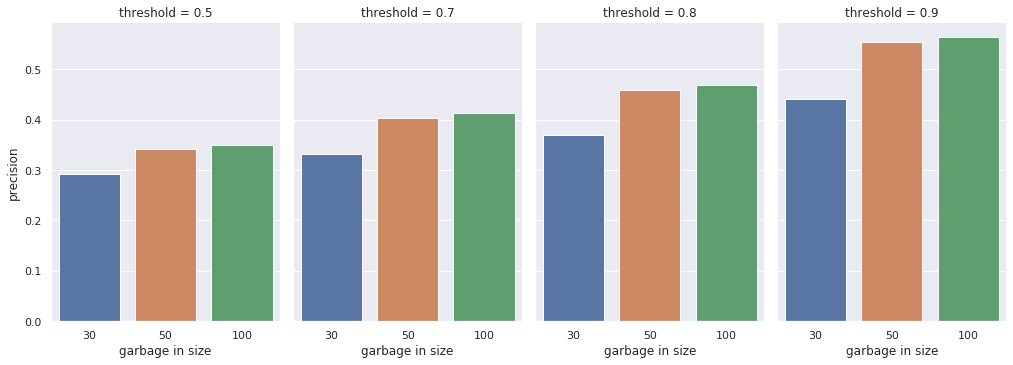

<Figure size 432x288 with 0 Axes>

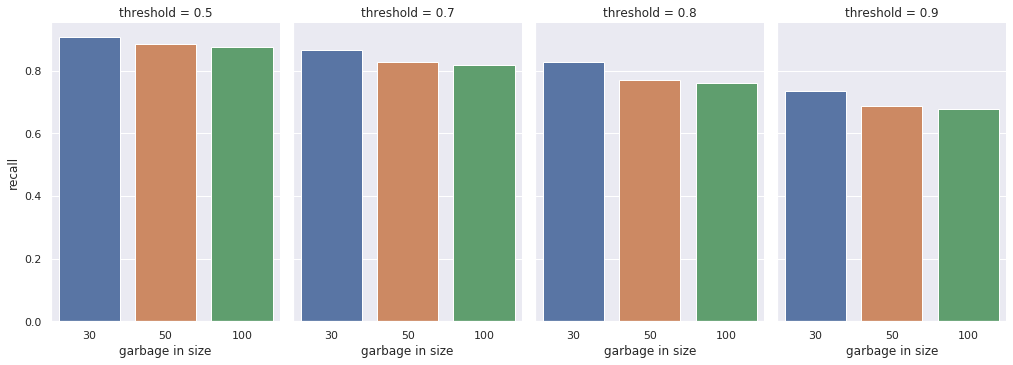

In [14]:
metric_barplot(metric='precision_score',mode='average_prediction')
metric_barplot(metric='recall_score',mode='average_prediction')

# Bar charts for metrics with majority voting strategy

,accuracy_score,precision_score,recall_score,f1_score,threshold
30,0.531401,0.283582,0.974359,0.439306,0.5
30,0.671498,0.359223,0.948718,0.521127,0.7
30,0.753623,0.421053,0.820513,0.556522,0.8
30,0.830918,0.538462,0.717949,0.615385,0.9
50,0.685990,0.367347,0.923077,0.525547,0.5
50,0.777778,0.453333,0.871795,0.596491,0.7
50,0.835749,0.545455,0.769231,0.638298,0.8
50,0.893720,0.729730,0.692308,0.710526,0.9
100,0.676329,0.360000,0.923077,0.517986,0.5
100,0.792271,0.471429,0.846154,0.605505,0.7


<Figure size 432x288 with 0 Axes>

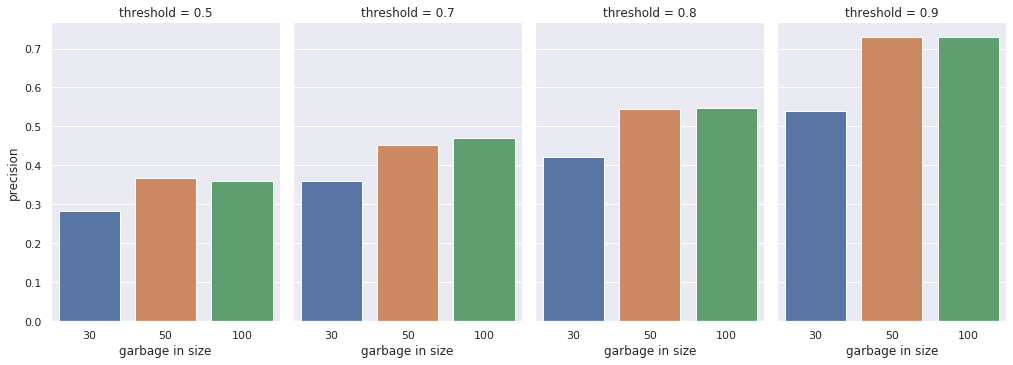

<Figure size 432x288 with 0 Axes>

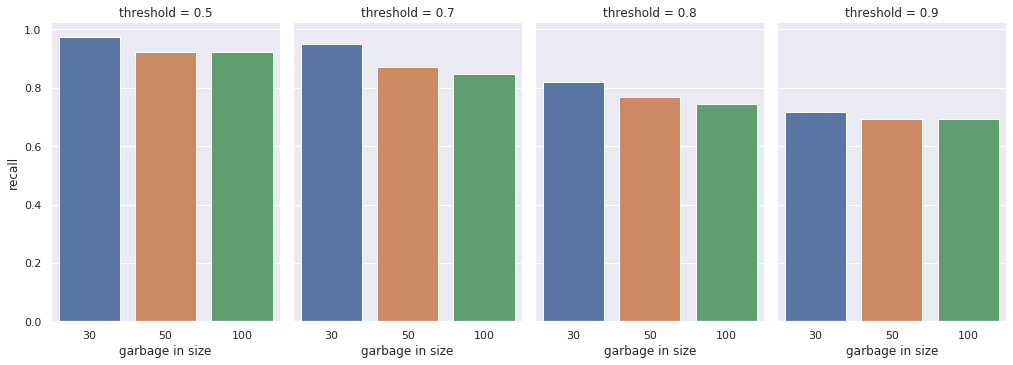

In [15]:
metric_barplot(metric='precision_score',mode='prediction_by_vote')
metric_barplot(metric='recall_score',mode='prediction_by_vote')



# Precision - Recall curve for DeepSet model on Hosono


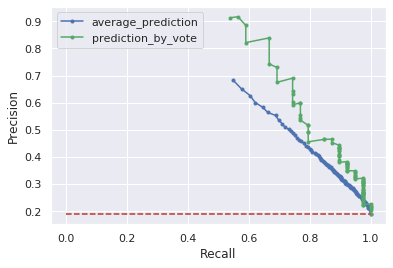

In [18]:
fig,ax = plt.subplots()
plot_pr_curve(mode='average_prediction',garbage_size='50',ax=ax)
plot_pr_curve(mode='prediction_by_vote',garbage_size='50',ax=ax)

# Precision - Recall curve for Deep Set model on SuperCon + Garbage in

In [19]:
import pandas as pd
auto50k = pd.read_csv('../data/experiments/classification_data/AUTO/1autoconsistent50.csv',index_col=0)
precision_50k, recall_50k = precision_recall_pandas(auto50k)

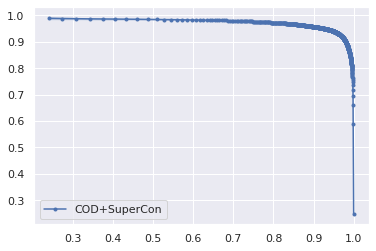

In [20]:

fig, axs = plt.subplots(1)
axs.plot(recall_50k.mean(axis=1).to_numpy(),precision_50k.mean(axis=1).to_numpy(),marker='.',label='COD+SuperCon')
axs.fill_between(recall_50k.mean(axis=1).to_numpy(),precision_50k.mean(axis=1).to_numpy()+precision_50k.std(axis=1).to_numpy(),precision_50k.mean(axis=1).to_numpy()-precision_50k.std(axis=1).to_numpy(),alpha = 0.3)
axs.legend()

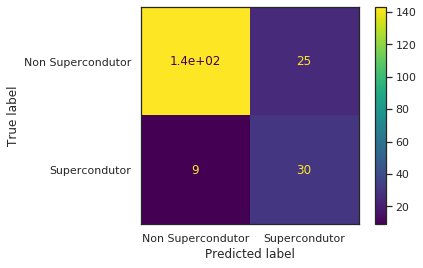

In [21]:
plot_confusion_matrix(0.8,mode='prediction_by_vote')

In [8]:
hosono = pd.read_csv('../data/experiments/classification_data/HOSONO/hosono_classification50.csv')

In [9]:
get_average_metrics(hosono,0.9)

NameError: name 'get_average_metrics' is not defined

In [ ]:
get_metrics_average(hosono,0.9,mode='prediction_by_vote')